# Compute Equatorial Upwelling Current from ECCO version 4 release 3

In [1]:
from glob import glob
import warnings
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import ecco_v4_py as ecco
import pych.ecco as pe

In [2]:
grid_dir = '/workspace/grids/llc90/'

In [3]:
uvel_download_dir = '/workspace/ecco/release3_alt/nctiles_monthly/UVELMASS/*.nc'
vvel_download_dir = '/workspace/ecco/release3_alt/nctiles_monthly/VVELMASS/*.nc'

In [4]:
ds = xr.open_mfdataset(glob(uvel_download_dir)+glob(vvel_download_dir))

In [5]:
g = pe.read_mds(grid_dir,iters=None)

/workspace/xmitgcm/xmitgcm/mds_store.py:850: UserWarning: Couldn't find available_diagnostics.log in /workspace/grids/llc90/ or /workspace/grids/llc90/. Using default version.
  "in %s or %s. Using default version." % (data_dir, grid_dir))


## Create mask defining the Equatorial Upwelling Current (EUC)

Consider the region $140^\circ$E-$80^\circ$W, $1.5^\circ$S-$1.5^\circ$N, from the surface to 400m depth.

In [6]:
lon_left = np.arange(140,180,1)
lon_right = np.arange(-180,-79.5,1)

In [7]:
lon_list = np.concatenate((lon_left,lon_right))

In [8]:
for fld in ['drF','dyG','dxG','XC','XC']:
    ds[fld] = g[fld]

In [9]:
ds['UVELMASS'] = ds.UVELMASS.where(ds.Z>-400)
ds['VVELMASS'] = ds.VVELMASS.where(ds.Z>-400)

In [ ]:
trsp_list = []
trsp_z_list = []
for lon in lon_list:
    pt1 = [lon,1.5]
    pt2 = [lon,-1.5]
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        trsp_ds = ecco.calc_section_vol_trsp(ds,pt1=pt1,pt2=pt2,section_name='EUC')
    trsp_list.append(trsp_ds['vol_trsp'].values)
    trsp_z_list.append(trsp_ds['vol_trsp_z'].where(g.Z>-400,drop=True).values)

In [ ]:
trsp_ds

In [ ]:
import pickle

In [ ]:
with open('/workspace/results/pickles/euc_eccov4r3.pkl','wb') as pkl:
    pickle.dump(trsp_list,pkl,-1)
    pickle.dump(trsp_list_z,pkl,-1)

In [12]:
euc_trsp = xr.DataArray(data=np.array(trsp_list),coords={'lon':lon_list},dims=('lon',))

In [13]:
euc_trsp_z= xr.DataArray(data=np.array(trsp_z_list),
             coords={'lon':lon_list,'Z':g.Z.where(g.Z>-400,drop=True).values},
             dims=('lon','Z'))

In [14]:
lon_index = np.arange(len(euc_trsp.lon))

In [15]:
lon_label_e = [f'{int(l)}$^\circ$E' for l in euc_trsp.lon.where(euc_trsp.lon>0,drop=True).values]
lon_label_w = [f'{-int(l)}$^\circ$W' for l in euc_trsp.lon.where(euc_trsp.lon<0,drop=True).values]

In [16]:
lon_label = lon_label_e+lon_label_w

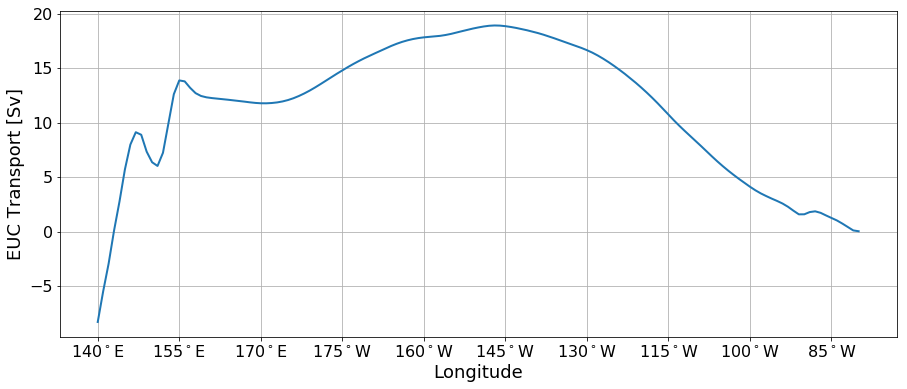

In [17]:
fig,ax = plt.subplots(1,1,figsize=(15,6))
ax.plot(lon_index,euc_trsp.values)
plt.grid();
dx = 15
ax.set_xticks(lon_index[slice(0,None,dx)])
ax.set_xticklabels(lon_label[slice(0,None,dx)]);
ax.set_ylabel('EUC Transport [Sv]')
ax.set_xlabel('Longitude');
fig.savefig('/h2/tsmith/Downloads/euc_timemean_eccov4r4.png',bbox_inches='tight',dpi=300)

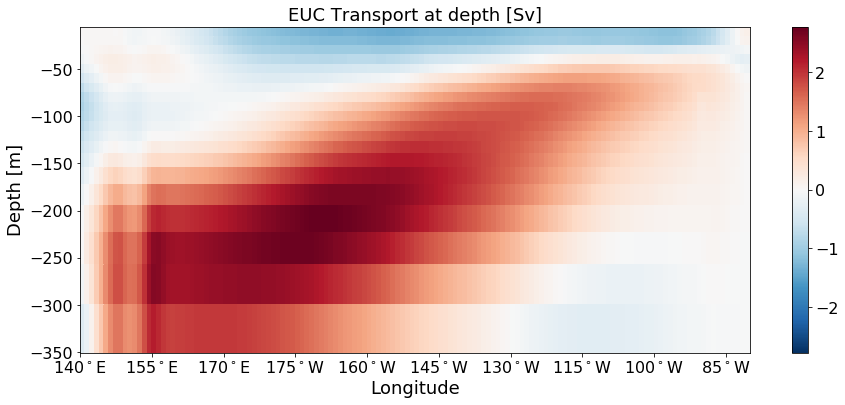

In [18]:
fig,ax = plt.subplots(1,1,figsize=(15,6))
vmax = np.abs(euc_trsp_z).max().values
levels=11
cf = ax.pcolormesh(lon_index,euc_trsp_z.Z.values,euc_trsp_z.T.values,
                   cmap='RdBu_r',vmin=-vmax,vmax=vmax)
plt.colorbar(cf)
dx = 15
ax.set_xticks(lon_index[slice(0,None,dx)])
ax.set_xticklabels(lon_label[slice(0,None,dx)]);
ax.set_title('EUC Transport at depth [Sv]')
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Longitude');
fig.savefig('/h2/tsmith/Downloads/euc_atdepth_timemean_eccov4r4.png',bbox_inches='tight',dpi=300)

## Make a dataset and save to a couple different formats

In [19]:
euc = xr.Dataset()
euc['trsp'] = euc_trsp
euc['trsp_z'] = euc_trsp_z

In [20]:
euc['lon_index'] = lon_index
euc['lon_label'] = lon_label

In [21]:
euc['trsp'].attrs['units']='Sv'
euc['trsp_z'].attrs['units']='Sv'

In [22]:
euc.to_netcdf('~/Downloads/euc_eccov4r4.nc')

In [23]:
df = euc['trsp'].to_dataframe()

In [24]:
df.to_csv('/h2/tsmith/Downloads/euc_eccov4r4.csv')